# Depthwise Convolution
:label:`ch_depthwise_conv_cpu`

In this section, we will follow the packing idea presented in :numref:`ch_packed_conv_cpu` to re-defined the computation of depthwise convolution and schedule it to run efficiently on CPUs. Similar to the 2-D convolution, tiling the data along the channel dimension and packing it into `NCHW[x]c` benefit the performance significantly.


In [1]:
import d2ltvm
import numpy as np
import tvm
from tvm import te
import timeit
import os
os.environ['KMP_AFFINITY']='granularity=fine,noduplicates,compact,1,0'

# target = 'llvm -mcpu=skylake-avx512'
target = 'llvm'

## Packing Data and Weight

Recall the depthwise convolution described in :numref:`ch_depthwise_conv`, it differs from the 2-D convolution by having each channel of the input data convolved with a separated kernel. Therefore, the packing mechanism of input data is exactly the same as we did in :numref:`ch_packed_conv_cpu`. Kernel is a bit different, as the size is in `[oc, 1, kh, kw]`, which means that there is no need to tile the input channel.

In other words, in the packing method below, we only pass one argument `c` to depict the channel, and another argument `tc` to depict the tiling size of channels. Other than that, it works very similarly as the `conv_pack` method defined in :numref:`ch_packed_conv_cpu`.


In [2]:
def depthwise_conv_pack(c, nh, nw, kh, kw, ph, pw, tc):
    """Pack data and weight for depthwise convolution
       Note that the input channel of kernel is specified as 1,
       and the output channel of kernel equals the input channel of data

    c : input channel of data and output channel of kernel
    nh, nw : input width and height
    kh, kw : kernel width and height
    ph, pw : height and width padding
    tc : the tiling size of channels
    """
    X = te.placeholder((c, nh, nw), name='X')
    K = te.placeholder((c, 1, kh, kw), name='K')
    PaddedX = d2ltvm.padding(X, ph, pw) if ph * pw != 0 else X
    # make sure the channel tiling is valid
    if c < tc:
        tc = c
    assert c % tc == 0
    # pack X and K
    PackedX = te.compute(
        (c//tc, nh+ph*2, nw+pw*2, tc),
        lambda c_out, x, y, c_in: PaddedX[c_out*tc + c_in, x, y],
        name='PackedX')
    PackedK = te.compute(
        (c//tc, 1, kh, kw, 1, tc),
        lambda c_out, _, x, y, __, c_in: K[
            c_out*tc + c_in, 0, x, y],
        name='PackedK')
    return X, K, PaddedX, PackedX, PackedK

## Computation

Like in :numref:`ch_packed_conv_cpu`, we also need to re-implement the depthwise convolution computation accordingly.


In [3]:
def depthwise_conv(c, nh, nw, kh, kw, ph, pw, sh, sw, tc):
    """depthwise conv

    c : number of channels for both input and output.
    nh, nw : input width and height
    kh, kw : kernel width and height
    ph, pw : height and width padding
    sh, sw : height and width strides
    tc : the tiling sizes of channels
    """
    X, K, PaddedX, PackedX, PackedK = depthwise_conv_pack(
        c, nh, nw, kh, kw, ph, pw, tc)
    # reduction axes
    rkh = te.reduce_axis((0, kh), name='rkh')
    rkw = te.reduce_axis((0, kw), name='rkw')
    # output height and weights
    oh = d2ltvm.conv_out_size(nh, kh, ph, sh)
    ow = d2ltvm.conv_out_size(nw, kw, pw, sw)
    # compute Y in the packed layout
    PackedY = te.compute(
        (c//tc, oh, ow, tc),
        lambda c_out, x, y, c_in: te.sum(
            (PackedX[c_out, x*sh+rkh, y*sw+rkw, c_in] *
             PackedK[c_out, 0, rkh, rkw, 0, c_in]),
            axis=[rkh, rkw]), name='PackedY')
    
    # Unpack the result
    Y = te.compute((c, oh, ow),
                    lambda c, x, y: PackedY[c//tc, x, y, c%tc],
                    name='Y')
    return X, K, Y, PaddedX, PackedX, PackedK, PackedY

Let's quickly compile it using the default scheduling to compute the results.


In [4]:
c, n, k, p, s, tc = 32, 64, 3, 1, 1, 16

X, K, Y, _, _, _, _ = depthwise_conv(c, n, n, k, k, p, p, s, s, tc)
mod = tvm.build(te.create_schedule(Y.op), [X, K, Y])

data, weight, out = d2ltvm.get_conv_data(c, c, n, k, p, s, tvm.nd.array, conv_type='depthwise')
mod(data, weight, out)

And then verify the result.


In [5]:
data, weight, bias, out_mx = d2ltvm.get_conv_data_mxnet(c, c, n, k, p, s, conv_type='depthwise')
d2ltvm.depthwise_conv_mxnet(data, weight, bias, out_mx, k, p, s)
np.testing.assert_allclose(out_mx[0].asnumpy(), out.asnumpy(), atol=1e-5)

## Schedule

The optimization strategy here is almost identical to `cache_block` defined in :numref:`ch_packed_conv_cpu`. The main  difference is in the channels, i.e. we don't need to reduce along the input channel dimension due to the compute nature of depthwise convolution.

The tiling sizes for channel and width are set to make sure that the working set of the inner loop which calculates the cached output fits in the cache.


In [6]:
# tiling sizes for channel and width
tc, tw = 16, 4

def depthwise_cached_block(c, n, k, p, s):
    X, K, Y, PaddedX, PackedX, PackedK, PackedY = depthwise_conv(
        c, n, n, k, k, p, p, s, s, tc)
    sch = te.create_schedule(Y.op)

    CachedY = sch.cache_write(PackedY, 'global')

    c_out, h, w, c_in = sch[PackedY].op.axis
    w_out, w_in = sch[PackedY].split(w, factor=tw)
    sch[PackedY].reorder(c_out, h, w_out, w_in, c_in)
    c_out_h = sch[PackedY].fuse(c_out, h)
    sch[PackedY].parallel(c_out_h)
    sch[CachedY].compute_at(sch[PackedY], w_out)

    cc_out, ch, cw, cc_in = sch[CachedY].op.axis
    kh, kw = sch[CachedY].op.reduce_axis
    sch[CachedY].reorder(cc_out, ch, kh, kw, cw, cc_in)
    sch[CachedY].vectorize(cc_in)
    sch[CachedY].unroll(cw)
    
    # Schedule the padding by adding thread-level parallelism
    if PaddedX != X:
        sch[PaddedX].parallel(PaddedX.op.axis[0])
    # Optimize the packing of X and K
    sch[PackedX].parallel(sch[PackedX].fuse(*PackedX.op.axis[0:2]))
    sch[PackedX].unroll(PackedX.op.axis[-1])
    sch[PackedK].parallel(sch[PackedK].fuse(*PackedK.op.axis[0:2]))
    sch[PackedK].unroll(PackedK.op.axis[-1])
    # Optimize the unpacking of Y
    sch[Y].parallel(sch[Y].fuse(*Y.op.axis[0:2]))
    sch[Y].unroll(Y.op.axis[-1])
    return sch, (X, K, Y)

# c, n, k, p, s were defined in the previous code block
sch, args = depthwise_cached_block(c, n, k, p, s)
# Uncomment the following line to see the long
# psuedo codes because of unrolling.
# tvm.lower(sch, args, simple_mode=True)

As the scheduling is vastly changed, let's do another round of sanity check.


In [7]:
mod = tvm.build(sch, args, target)
ctx = tvm.device(target, 0)
data, weight, out = d2ltvm.get_conv_data(
            c, c, n, k, p, s, lambda x: tvm.nd.array(x, device=ctx), conv_type='depthwise')
mod(data, weight, out)

data, weight, bias, out_mx = d2ltvm.get_conv_data_mxnet(c, c, n, k, p, s, conv_type='depthwise')
d2ltvm.depthwise_conv_mxnet(data, weight, bias, out_mx, k, p, s)
np.testing.assert_allclose(out_mx[0].asnumpy(), out.asnumpy(), atol=1e-5)

## Benchmark

Finally, let's benchmark the results against MXNet.

The following benchmarking method is very similar to `bench_conv_tvm` defined in :numref:`ch_conv_cpu`, with two differences:

1. The signature of the convolution functions (depthwise convolution only takes one channel input).
2. The way to compute the FLOPs of computation (the input channel dimension of depthwise convolution is 1).

We don't unify the benchmarking of depthwise convolution into the `bench_conv_tvm` method in order to reduce the possible confusion it may cause.


In [8]:
# Save to the d2ltvm package.
def bench_depthwise_conv_tvm(func, sizes, target):
    def workload(nrepeats):
        timer = mod.time_evaluator(mod.entry_name, dev=ctx, number=nrepeats)
        return timer(x, k, y).mean * nrepeats
    gflops, times = [], []
    for (c, n, k) in sizes:
        args = c, n, k, (k-1)//2, 1 # c, n, k, p, s
        s, (X, K, Y) = func(*args)
        mod = tvm.build(s, [X, K, Y], target)
        ctx = tvm.device(target, 0)
        x, k, y = d2ltvm.get_conv_data(
            args[0], *args, lambda x: tvm.nd.array(x, device=ctx), conv_type='depthwise')
        times.append(d2ltvm.bench_workload(workload))
        gflops.append(d2ltvm.conv_gflop(1, *args))
    return np.array(gflops) / np.array(times)

Similarly, the timing methods for depthwise convolution in MXNet are largely duplicated from the corresponding methods defined in :numref:`ch_conv_cpu`.


In [9]:
# Save to the d2ltvm package.
def depthwise_conv_timer_mxnet(c, n, k, ctx):
    """Benchmark convolution in MXNet

    c : input, output channels
    n : input width and height
    k : kernel width and height
    """
    timer = timeit.Timer(
        setup='import d2ltvm\n'
        'import mxnet as mx\n'
        'c, n, k, p, s = %d, %d, %d, %d, 1\n'
        'data, weight, bias, out = d2ltvm.get_conv_data_mxnet(\n'
        '    c, c, n, k, p, s, "%s", "%s")'%(c, n, k, (k-1)//2, ctx, 'depthwise'),
        stmt='d2ltvm.depthwise_conv_mxnet(data, weight, bias, out, k, p, s);'
        'out.wait_to_read()')
    return timer.timeit

# Save to the d2ltvm package.
def bench_depthwise_conv_mxnet(sizes, ctx='cpu'):
    """Return the GFLOPS of MXNet convolution"""
    return [d2ltvm.conv_gflop(1, c, n, k, (k-1)//2, 1) /
            d2ltvm.bench_workload(depthwise_conv_timer_mxnet(c, n, k, ctx))
            for c, n, k in sizes]

Now, let's benchmark against our MXNet baseline. We see that our depthwise convolution performance consistently outperform MXNet. As depthwise convolution is a memory-bound operator, we see that the performance saturates after channel size gets to 128.


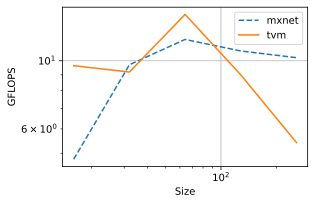

In [10]:
channels = 2**np.arange(4, 9)
sizes = [(int(c), 64, 3) for c in channels] # a list of (c, n, k)
tvm_gflops = bench_depthwise_conv_tvm(depthwise_cached_block, sizes, target)
mxnet_gflops = bench_depthwise_conv_mxnet(sizes)
d2ltvm.plot_gflops(channels, [mxnet_gflops, tvm_gflops], ['mxnet', 'tvm'])

## Summary

- We can get good performance out of depthwise convolution by following the same rules of optimizing 2-D convolution.

## Exercises

- Try different tiling sizes.
